In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from collections import Counter
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud

# Download NLTK resources (run once)
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)

# Set style for plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
%matplotlib inline

In [5]:
# Load the Reddit dataset from the raw data directory
data_path = '../data/raw/reddit.csv'
df = pd.read_csv(data_path)

In [8]:
# Display basic information and first few rows
print("Dataset Info:")
df.info()
print("\nDataset Description:")
print(df.describe(include='all'))
print("\nFirst 5 Rows:")
df.head()

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37249 entries, 0 to 37248
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   clean_comment  37149 non-null  object
 1   category       37249 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 582.1+ KB

Dataset Description:
       clean_comment      category
count          37149  37249.000000
unique         36799           NaN
top                            NaN
freq             115           NaN
mean             NaN      0.202771
std              NaN      0.778515
min              NaN     -1.000000
25%              NaN      0.000000
50%              NaN      0.000000
75%              NaN      1.000000
max              NaN      1.000000

First 5 Rows:


,clean_comment,category
0,family mormon have never tried explain them t...,1
1,buddhism has very much lot compatible with chr...,1
2,seriously don say thing first all they won get...,-1
3,what you have learned yours and only yours wha...,0
4,for your own benefit you may want read living ...,1


Missing values:
 clean_comment    100
category           0
dtype: int64

Missing percentage:
 clean_comment    0.268464
category         0.000000
dtype: float64


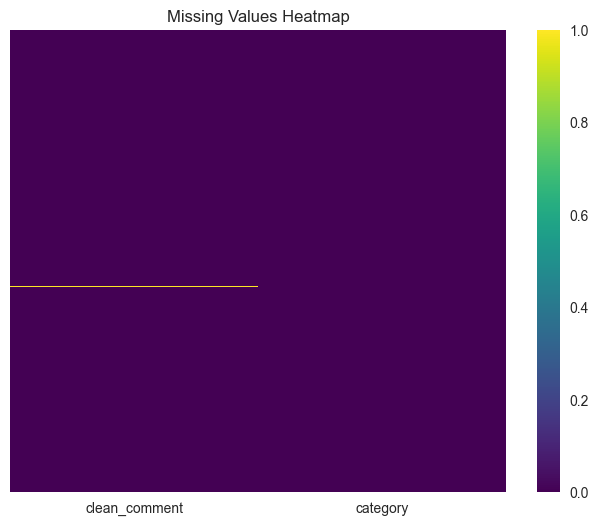

In [9]:
# Missing values per column
missing = df.isnull().sum()
missing_pct = (missing / len(df)) * 100
print("Missing values:\n", missing)
print("\nMissing percentage:\n", missing_pct)

# Visualize missing values (if any)
if missing.sum() > 0:
    plt.figure(figsize=(8, 6))
    sns.heatmap(df.isnull(), cbar=True, yticklabels=False, cmap='viridis')
    plt.title('Missing Values Heatmap')
    plt.show()

Sentiment distribution:
 category
-1     8277
 0    13142
 1    15830
Name: count, dtype: int64

Sentiment Distribution (%):
sentiment_label
Positive    42.50
Neutral     35.28
Negative    22.22
Name: proportion, dtype: float64


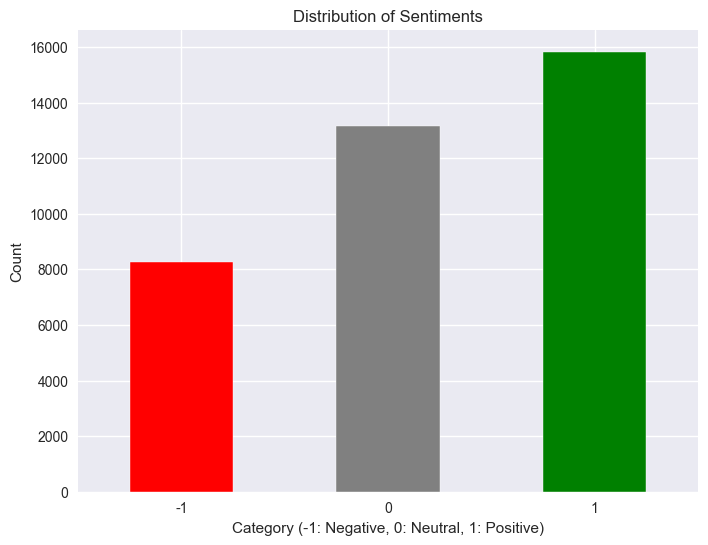

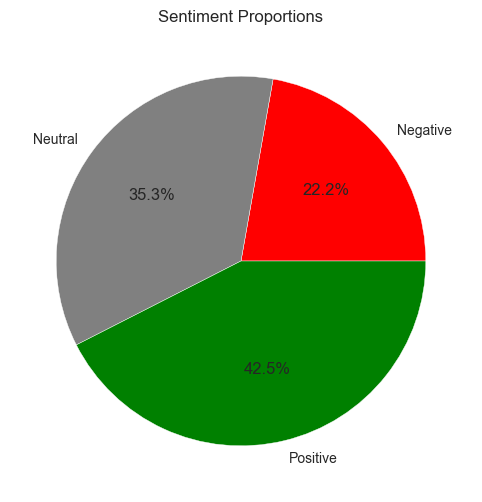

In [14]:
# Value counts for category (-1: negative, 0: neutral, 1: positive)
sentiment_counts = df['category'].value_counts().sort_index()
print("Sentiment distribution:\n", sentiment_counts)

# Map category values to labels for clarity
sentiment_map = {-1: 'Negative', 0: 'Neutral', 1: 'Positive'}
df['sentiment_label'] = df['category'].map(sentiment_map)

# Display percentage distribution
print("\nSentiment Distribution (%):")
print((df['sentiment_label'].value_counts(normalize=True) * 100).round(2))

# Bar plot
plt.figure(figsize=(8, 6))
sentiment_counts.plot(kind='bar', color=['red', 'gray', 'green'])
plt.title('Distribution of Sentiments')
plt.xlabel('Category (-1: Negative, 0: Neutral, 1: Positive)')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

# Pie chart for proportions
plt.figure(figsize=(8, 6))
plt.pie(sentiment_counts.values, labels=['Negative', 'Neutral', 'Positive'], autopct='%1.1f%%', colors=['red', 'gray', 'green'])
plt.title('Sentiment Proportions')
plt.show()

Text length statistics:
 count    37149.000000
mean       181.388705
std        358.454956
min          1.000000
25%         38.000000
50%         80.000000
75%        184.000000
max       8665.000000
Name: text_length, dtype: float64


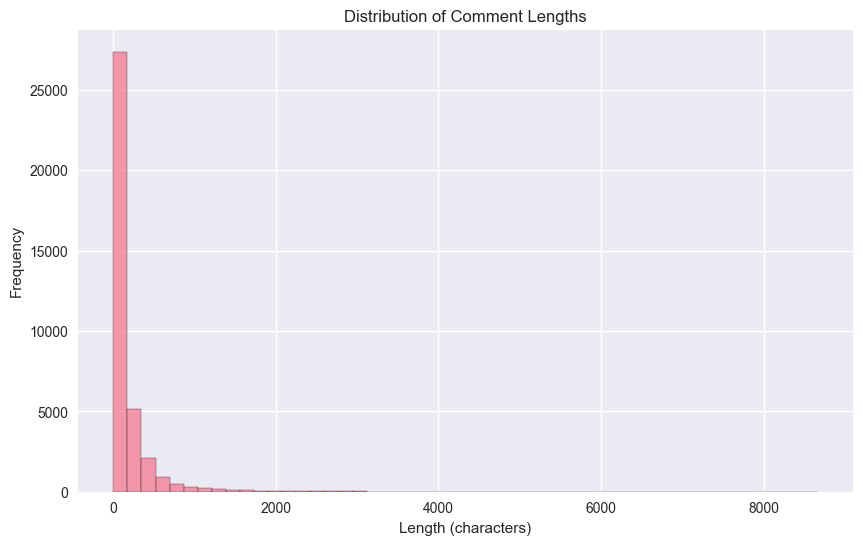

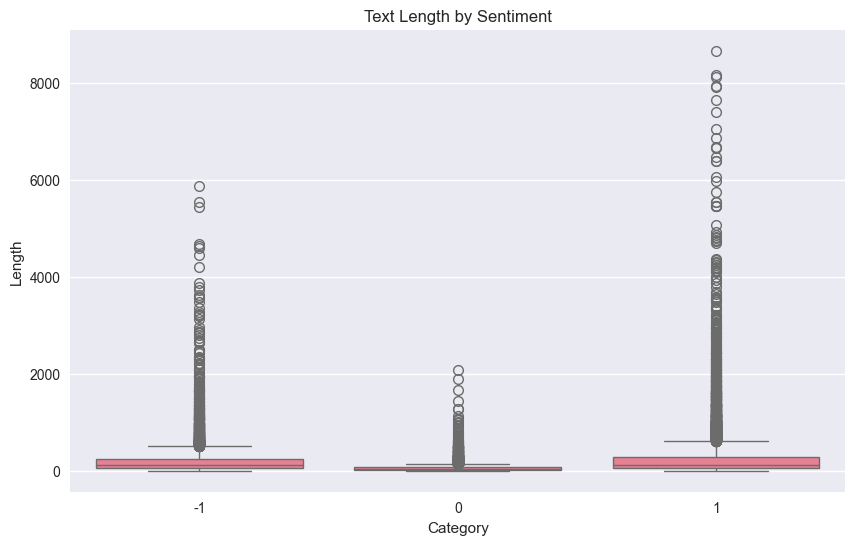

In [15]:
# Compute text lengths
df['text_length'] = df['clean_comment'].str.len()

# Basic stats
print("Text length statistics:\n", df['text_length'].describe())

# Histogram
plt.figure(figsize=(10, 6))
plt.hist(df['text_length'], bins=50, edgecolor='black', alpha=0.7)
plt.title('Distribution of Comment Lengths')
plt.xlabel('Length (characters)')
plt.ylabel('Frequency')
plt.show()

# Boxplot by sentiment
plt.figure(figsize=(10, 6))
sns.boxplot(x='category', y='text_length', data=df)
plt.title('Text Length by Sentiment')
plt.xlabel('Category')
plt.ylabel('Length')
plt.show()

In [20]:
df.sample(5)

,clean_comment,category,sentiment_label,text_length
31762,super anti bjp but this guy equally useless f...,1,Positive,543.0
22250,NaN,0,Neutral,NaN
23583,ोीी ो टकले ैं top top kek kek not offending y...,1,Positive,116.0
1660,final exit polls across the board png,0,Neutral,37.0
22802,kejriwal zindabad,0,Neutral,18.0


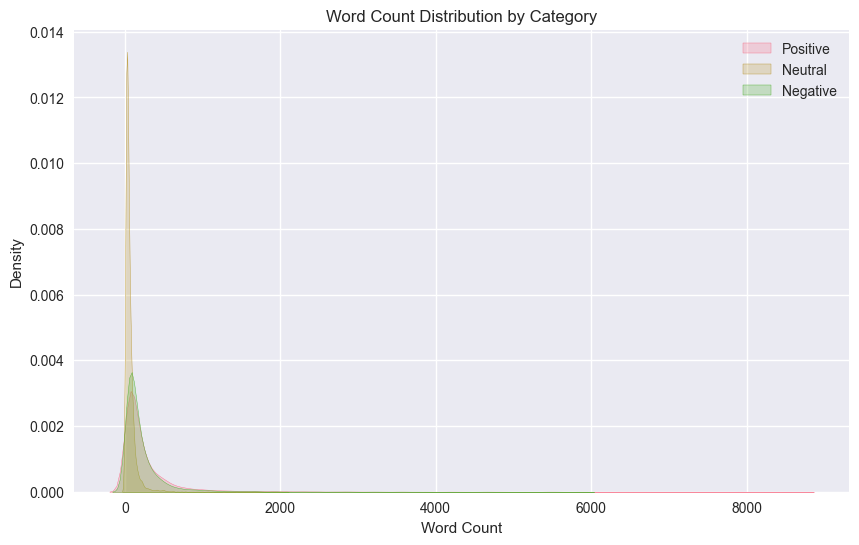

In [16]:
# Plot word count distribution by category
plt.figure(figsize=(10, 6))
sns.kdeplot(df[df['category'] == 1]['text_length'], label='Positive', fill=True)
sns.kdeplot(df[df['category'] == 0]['text_length'], label='Neutral', fill=True)
sns.kdeplot(df[df['category'] == -1]['text_length'], label='Negative', fill=True)
plt.title('Word Count Distribution by Category')
plt.xlabel('Word Count')
plt.ylabel('Density')
plt.legend()
plt.show()

In [33]:
# The median length of each comment
median_word_counts = df.groupby('category')['text_length'].median()
print(median_word_counts)

category
-1    119.0
 0     39.0
 1    127.0
Name: text_length, dtype: float64


In [21]:
# Function to display samples
def display_samples(category, n=3):
    samples = df[df['category'] == category]['clean_comment'].dropna().sample(n, random_state=42)
    print(f"\nSamples for category {category}:\n{'-'*50}")
    for i, text in enumerate(samples, 1):
        print(f"{i}. {text[:100]}...")

# Display for each category
for cat in sorted(df['category'].unique()):
    display_samples(cat)


Samples for category -1:
--------------------------------------------------
1.  ashok khemka must munching popcorn sitting some dimly lit office some xyz department and must tryin...
2.  comment this answer you didn need include the unimportant story the answer unscientific the questio...
3. from article trump brought india aid during rambling press appearance cabinet meeting defended his p...

Samples for category 0:
--------------------------------------------------
1. context for the oblivious butterflies ece...
2. where can get one ...
3. paisa kitna milega ...

Samples for category 1:
--------------------------------------------------
1.  has ended but wait there see you next time does that mean sequel confirmed ...
2. dammit good and got good speechwriters let see the potential headlines tomorrow vhp miffed modi athe...
3.  all aspiring music producer who mainly does hip hop and pop records currently completing higher nit...


In [34]:
# Combine all comments into one large string
all_text = ' '.join(df['clean_comment'].dropna().astype(str).tolist())

# Count the frequency of each character
char_frequency = Counter(all_text)

# Convert the character frequency into a DataFrame for better display
char_frequency_df = pd.DataFrame(char_frequency.items(), columns=['character', 'frequency']).sort_values(by='frequency', ascending=False)

char_frequency_df.tail(20)

,character,frequency
1315,完,1
1316,慵,1
1317,懒,1
346,⊂,1
813,嵌,1
815,芯,1
818,藏,1
823,另,1
827,乱,1
829,瓜,1


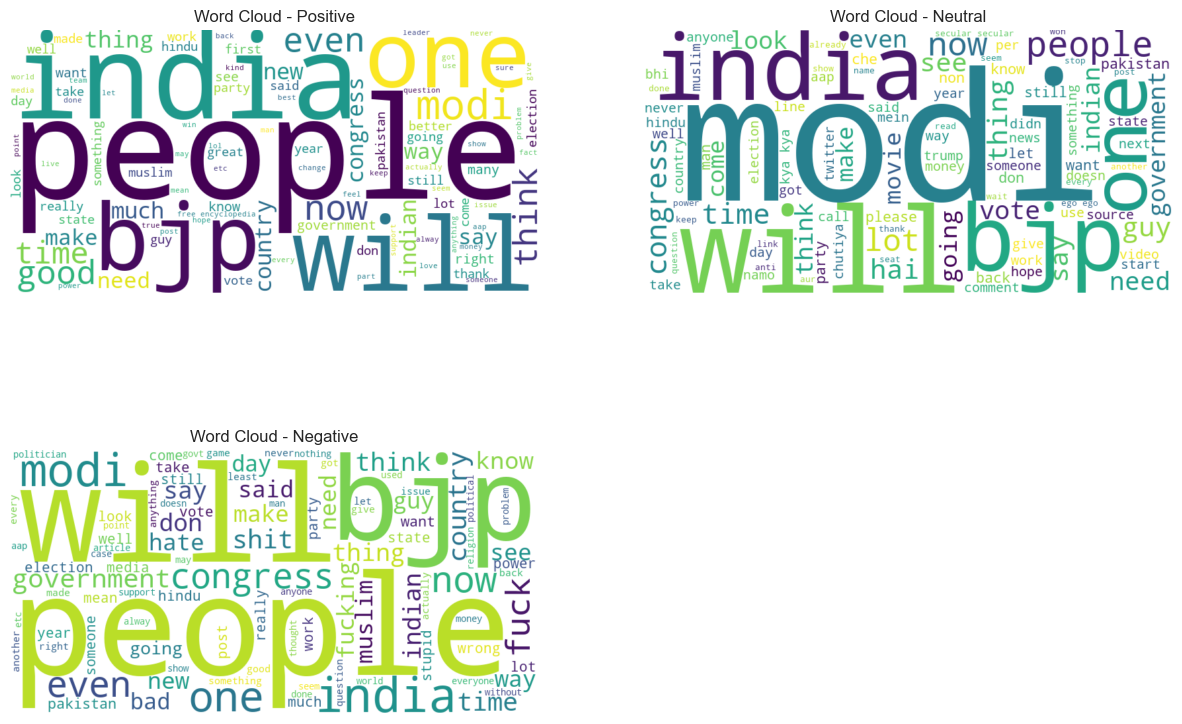

In [29]:
# Function to clean text for word cloud
def clean_text(text):
    if pd.isnull(text):
        return ''
    text = re.sub(r'[^\w\s]', '', str(text).lower())
    return text

# Generate word clouds for each sentiment
sentiments = ['Positive', 'Neutral', 'Negative']
plt.figure(figsize=(15, 10))
for i, sentiment in enumerate(sentiments, 1):
    plt.subplot(2, 2, i)
    text = ' '.join(df[df['sentiment_label'] == sentiment]['clean_comment'].apply(clean_text))
    wordcloud = WordCloud(width=800, height=400, background_color='white', max_words=100).generate(text)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Word Cloud - {sentiment}')
    plt.axis('off')
plt.show()

In [30]:
# Function to get top N words
def get_top_words(text_series, n=10):
    words = ' '.join(text_series.apply(clean_text)).split()
    word_counts = Counter(words)
    return pd.DataFrame(word_counts.most_common(n), columns=['Word', 'Count'])

# Display top 10 words for each sentiment
sentiments = ['Positive', 'Neutral', 'Negative']
for sentiment in sentiments:
    print(f"\nTop 10 Words for {sentiment}:")
    print(get_top_words(df[df['sentiment_label'] == sentiment]['clean_comment']))


Top 10 Words for Positive:
   Word  Count
0   the  37476
1   and  19210
2  that  10002
3   for   8329
4  this   8043
5   you   7162
6   are   6497
7  have   5472
8  they   5382
9   not   5313

Top 10 Words for Neutral:
   Word  Count
0   the   5731
1   and   2016
2  this   1624
3   you   1578
4   for   1350
5  that   1311
6   are   1091
7  same   1031
8   not    865
9  what    854

Top 10 Words for Negative:
   Word  Count
0   the  14553
1   and   7738
2  that   4151
3  this   3832
4   for   3314
5   you   3066
6   are   2981
7  they   2562
8   not   2526
9  have   2202


### Key Insights:
1. **Dataset Size**: The dataset has 37,249 entries with 'clean_comment' (text) and 'category' (sentiment: -1, 0, 1).
2. **Missing Values**: There are 100 missing comments, which need handling (e.g., imputation or removal).
3. **Sentiment Distribution**: The dataset may show class imbalance (check plot); consider oversampling/weighting for modeling.
4. **Text Characteristics**: Word counts vary (check histogram); long comments may need truncation for efficient modeling.
5. **Common Words**: Word clouds and top words highlight frequent terms; consider stop-word removal for better feature extraction.

### Next Steps:
- Preprocess data: Handle missing values, normalize text, remove stop words.
- Feature engineering: Create TF-IDF or embeddings for modeling.
- Plan YouTube data integration: Test API/scraping for comment collection.
- Save processed data to 'data/processed' and version with DVC.